Principal Component Analysis of UsArrests Dataset.

This data set contains statistics, in arrests per 100,000 residents,
for assault, murder, and rape in each of the 50 US states in 1973. Also given is the
percent of the population living in urban areas.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import KMeans
from pylab import rcParams

%matplotlib inline

df = pd.read_csv("UsArrests.csv",index_col='City')
df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


In [2]:
# Examin the dataset.
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [3]:
# Checking for null values
df.isnull().sum()

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [4]:
# Renaming 'City' column as 'State'
df = df.rename(columns={'City': 'State'})

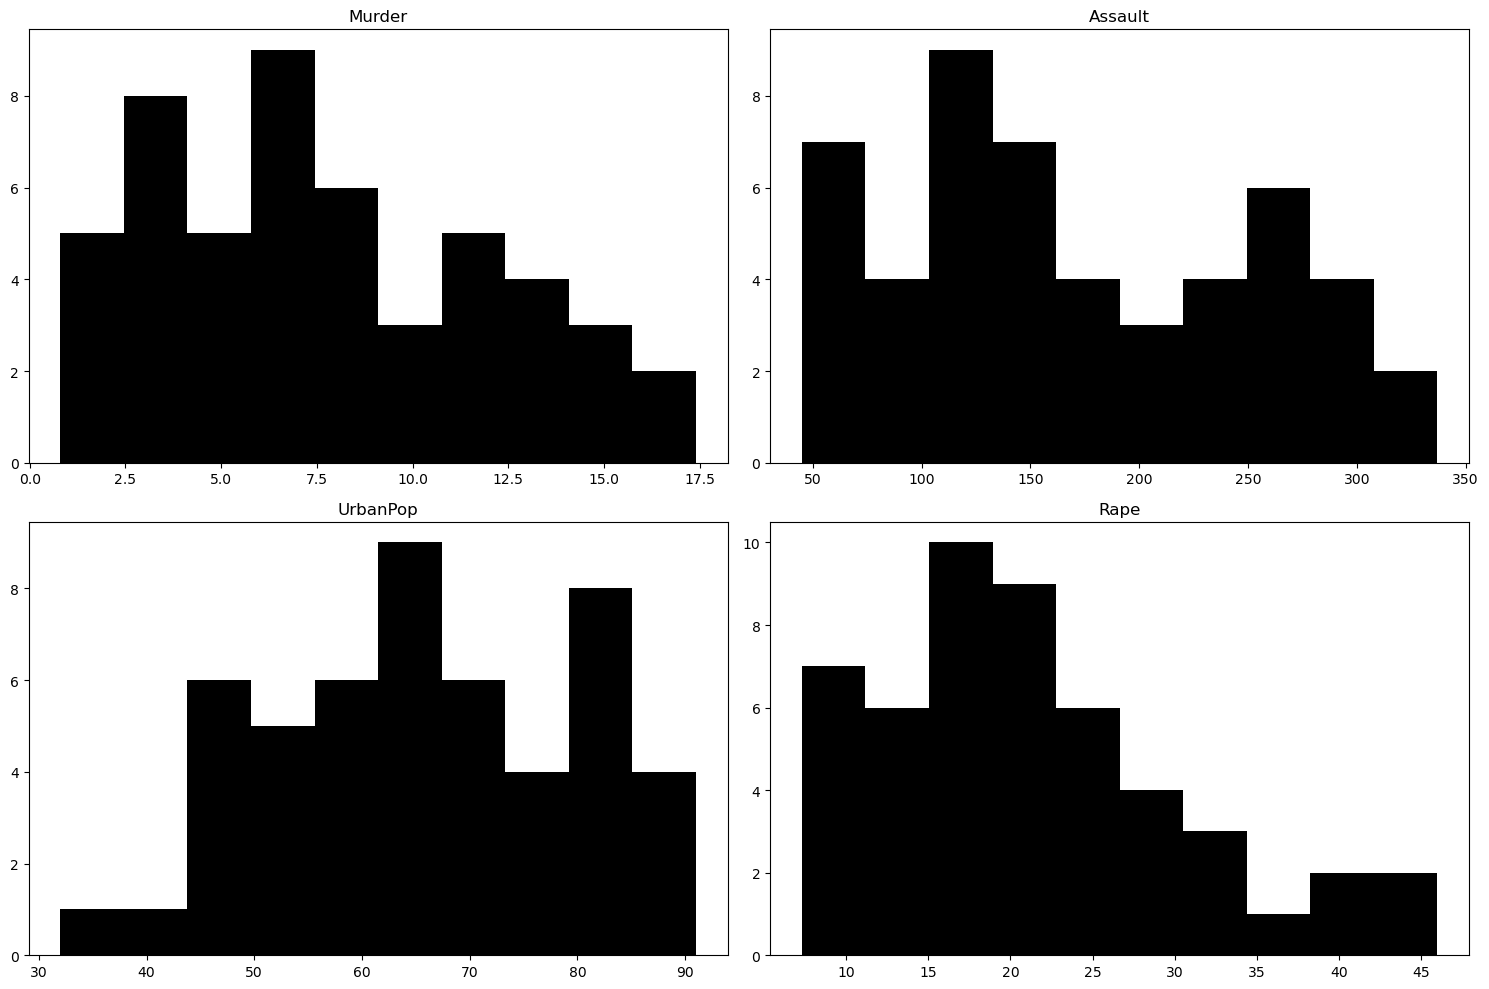

In [5]:
# Plot histograms
histograms = df.hist(color='black', grid=False, figsize=(15, 10)) #This can also be done for each column individually by calling hist on that column
plt.tight_layout()
plt.show()


In [6]:
#Scalling the data
scaler = StandardScaler()

df[['Murder', 'Assault', 'UrbanPop', 'Rape'
         ]] = scaler.fit_transform(df[['Murder', 'Assault', 'UrbanPop', 'Rape']])

df.head()

,Murder,Assault,UrbanPop,Rape
City,,,,
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


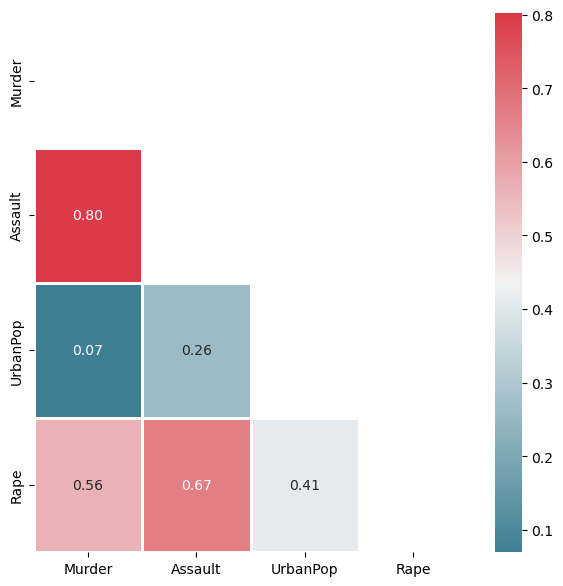

In [7]:
# Plotting the heat map to understand the correlations.

colormap = sns.diverging_palette(220, 10, as_cmap=True)

corrs = df.corr()

# Plot figsize
fig, ax = plt.subplots(figsize=(7, 7))

dropSelf = np.zeros_like(corrs)
dropSelf[np.triu_indices_from(dropSelf)] = True

ax = sns.heatmap(corrs, cmap=colormap, annot=True, fmt=".2f",
                     mask=dropSelf, linewidth=2)

plt.show()


The Above heat map shows there are strong correlation between
1 Murder and Assault
2.Rape and Assualt

also there is correlation between
1 Murder and Urbanpop
2 Assault and Urbanpop

Therefore, from the heatmap it is very hard to reduce the dimensionality of the data
and Principal component analysis can be used.

In [8]:
# Performing PCA
pcamodel=PCA().fit(df)
pca = pcamodel.fit_transform(df)

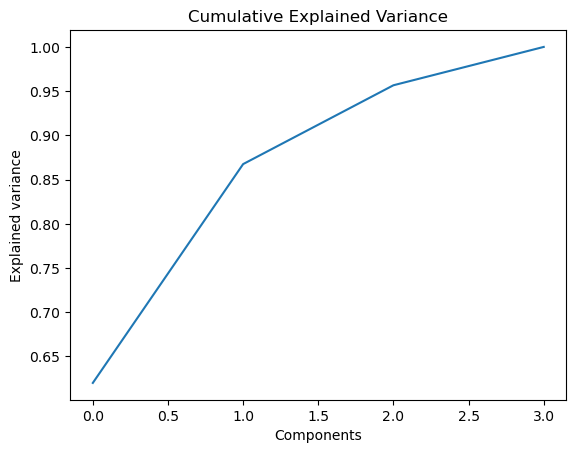

In [9]:


# Finding out the number of components according to these explained variance ratio
plt.ylabel('Explained variance')
plt.xlabel('Components')
plt.title("Cumulative Explained Variance")
plt.plot(np.cumsum(pcamodel.explained_variance_ratio_))

This graph shows 88% of data can be explained by 1 component
95% of the data can be explained by 2 components.
100% of the data can be explained by 3 components.


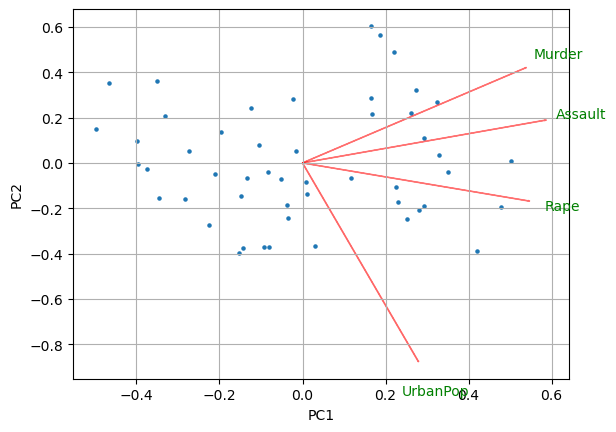

In [10]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,s=5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'green', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

myplot(pca[:,0:2],np.transpose(pcamodel.components_[0:2, :]),list(df.columns))
plt.show()

Each point on a biplot is the projected observation, transformed from the original data. The importance of each feature is indicated by the length of the arrows on the biplot. This corresponds to the magnitude of the values in the eigenvectors. 

From this biplot, we see that Urbanpop and Assualt
are the most important features as the arrows to each of these dominate the biplot.


In [11]:
# Feature importance
pd.set_option('display.float_format', lambda x: '%.3f' % x) #change precision to see more decimal places

pc1 = abs( pcamodel.components_[0] ) #components x features - access at index 0 to get the first component
pc2 = abs( pcamodel.components_[1] )

feat_df = pd.DataFrame()
feat_df["Features"] = list(df.columns)
feat_df["PC1 Importance"] = pc1
feat_df["PC2 Importance"] = pc2
feat_df

,Features,PC1 Importance,PC2 Importance
0,Murder,0.536,0.418
1,Assault,0.583,0.188
2,UrbanPop,0.278,0.873
3,Rape,0.543,0.167


After quantification , we can see that UrbanPop has highest importance in second principle component
while Murder, Assualt and Rape has highest importance in the first principle component.

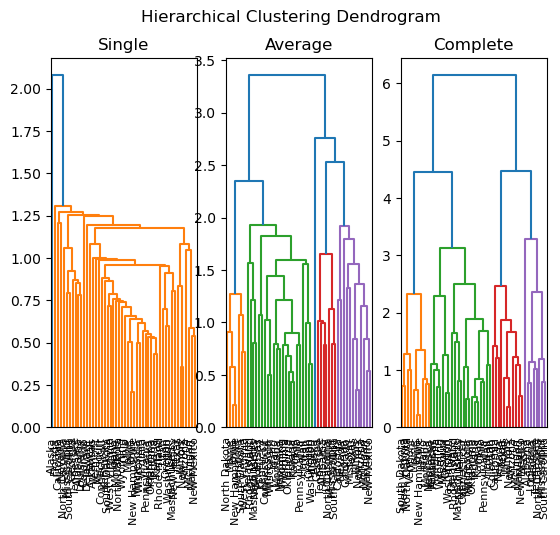

In [12]:
# Hierarchical clustering

pca_df = pd.DataFrame(pca, index = df.index)
pca_df.head()

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

agg_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = agg_model.fit(pca_df)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.suptitle('Hierarchical Clustering Dendrogram')
ax1.set_title("Single")
dendrogram(linkage(pca_df, method='single'), labels=pca_df.index, ax=ax1) #change method: eg. single, average, complete...
ax2.set_title("Average")
dendrogram(linkage(pca_df, method='average'), labels=pca_df.index, ax=ax2)
ax3.set_title("Complete")
dendrogram(linkage(pca_df, method='complete'), labels=pca_df.index, ax=ax3)
plt.show()

To choose the optimal number of clusters,we look for the clusters with the longest “branches” or the “longest dendrogram distance”.
The linkage criterion determines which distance to use between the given sets of observations.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


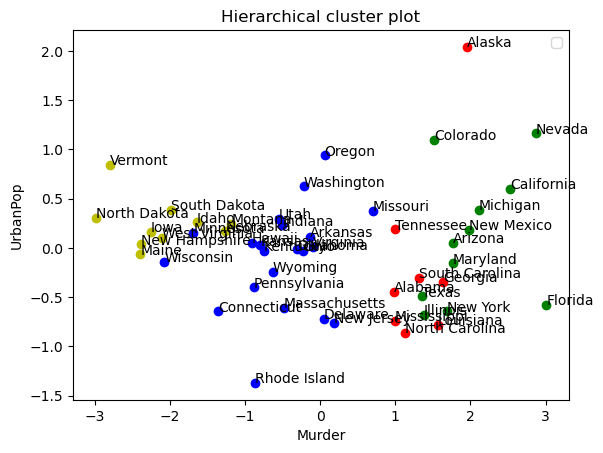

In [19]:
# We extract the first two components
x = pca[:,0]
y = pca[:,2]

# Fit Hierarchical Clustering model.
k=4
cluster_model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',
                                      linkage='complete')
cluster = cluster_model.fit_predict(pca_df)

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster == i],y[cluster == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = pca_df.index[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("Hierarchical cluster plot")
ax.set_xlabel("Murder")
ax.set_ylabel("UrbanPop")
ax.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


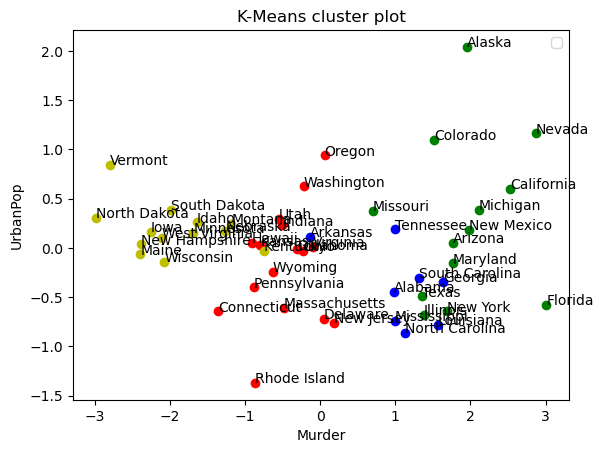

In [20]:
from sklearn.cluster import KMeans

# We extract the first two components
x = pca[:,0]
y = pca[:,2]

# Fit k-means
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(pca_df)
cent = kmeans.cluster_centers_

# Plot clusters
fig, ax = plt.subplots()
colours = 'rbgy'
for i in range(0,k):
    ax.scatter(x[cluster_labels == i],y[cluster_labels == i],c = colours[i]) 

for i in range(0,len(x)):
        txt = pca_df.index[i]
        ax.annotate(txt, (x[i], y[i]))
ax.set_title("K-Means cluster plot")
ax.set_xlabel("Murder")
ax.set_ylabel("UrbanPop")
ax.legend()

Above 2 graphs are almost identical.There is not much difference between the k means cluster and hierarchical cluster.The default of the KMeans cluster is Euclidean distance and it has a cluster value of 4.Therefore the only difference was the lincage method.

The blue data points represent areas with high murder rates but low to medium urban populations. The dark green data points show high to mid range murder rates with a high urban population. The light green points represent lower murder rates but low to middle urban populations. Lastly, Red data points  represents areas with low murder rates and low urban populations.


